In [19]:
import pandas as pd
import seaborn as sns
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def log(*any):
    for a in any:
        print(a, end=' ')
    print('\n--------------------------------------------------------------------------------------------------')

In [ ]:
https://www.kaggle.com/code/janiobachmann/bank-marketing-campaign-opening-a-term-deposit
https://archive.ics.uci.edu/dataset/222/bank+marketing

Input variables:
   # bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
   # other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [2]:
# 1 load dataset and show info

dataset_url = 'dataset/bank.csv'
df_full = pd.read_csv(dataset_url)

log(df_full.info())
log(df_full.head())
log('Rows:', df_full.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None 
---------------------------------------------------------------------------------------------

In [3]:
# 2 manage empty values (not needed in our case)

corrupted_feature = [feature for feature in df_full.columns if df_full[feature].isnull().sum() > 0]
if len(corrupted_feature):
    for feature in corrupted_feature:
        print(feature, df_full[feature].isnull().sum(), 'missing values')
        # fill with default value
else:
    print("No missing value found")

No missing value found


In [4]:
# data set is balanced
target = 'deposit'

log('target: ', df_full[target].value_counts())

target:  deposit
no     5873
yes    5289
Name: count, dtype: int64 
--------------------------------------------------------------------------------------------------


In [5]:
# analise numerical data
log(df_full.describe())

                age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  


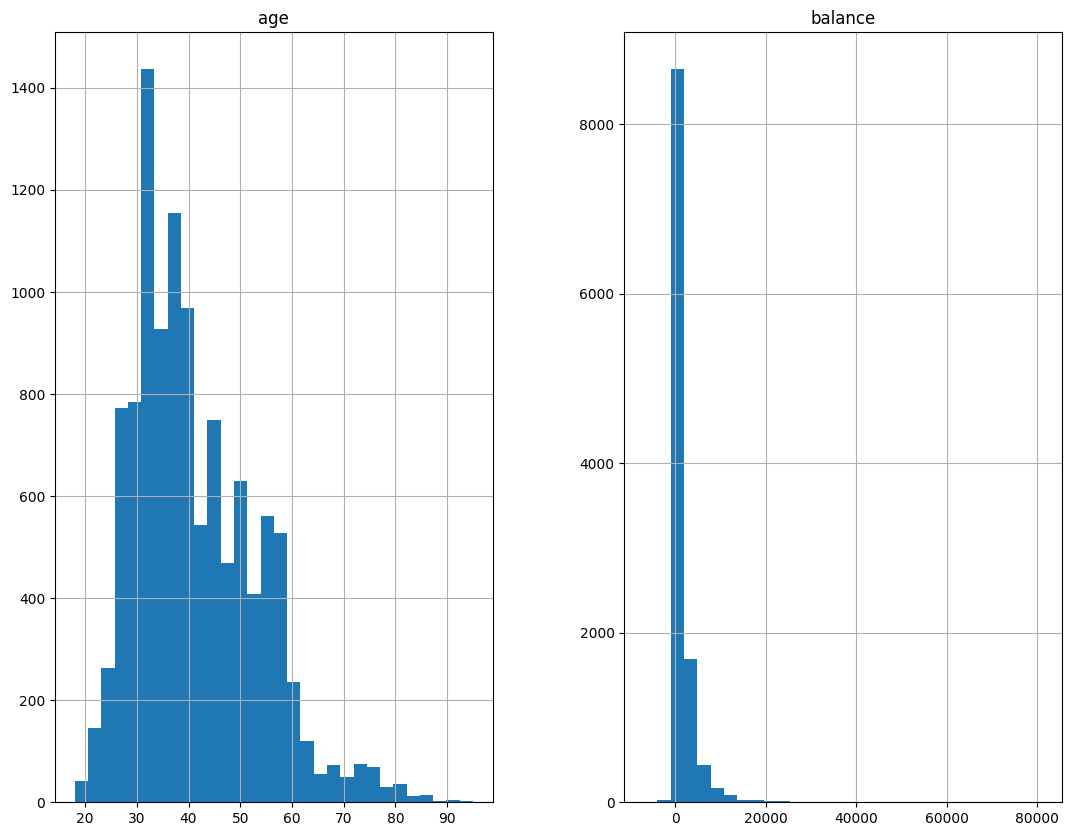

In [6]:
numerical_features = ['age', 'balance']
df_full[numerical_features].hist(bins = 30, figsize=(13,10))
plt.show()

In [7]:
# analise categorical data
for feature in df_full.select_dtypes(include=['object']):
    log(df_full[feature].value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64 
--------------------------------------------------------------------------------------------------
marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64 
--------------------------------------------------------------------------------------------------
education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64 
--------------------------------------------------------------------------------------------------
default
no     10994
yes      168
Name: count, dtype: int64 
--------------------------------------------------------------------------------------------------
housing
no     5881
yes    5281
Name: count, dtype: i

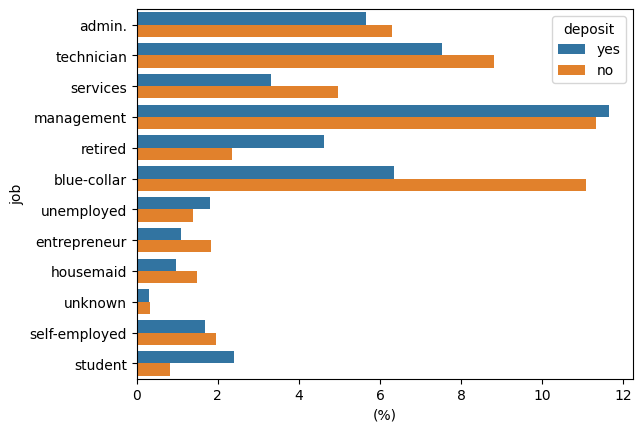

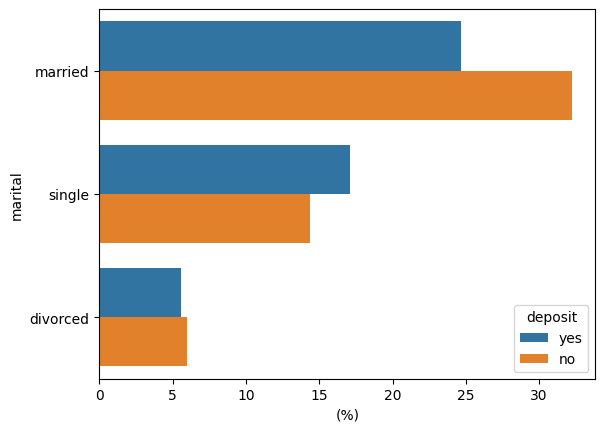

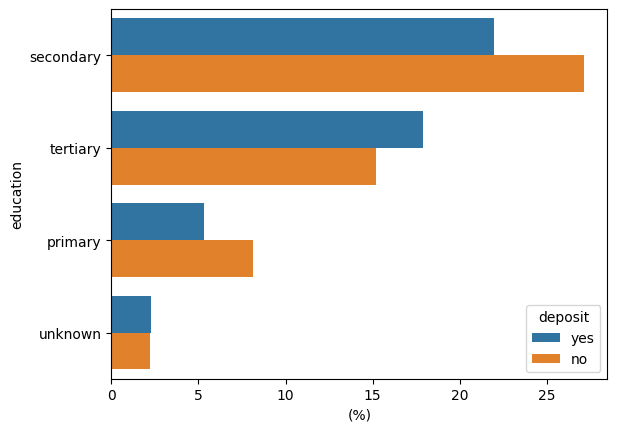

In [8]:
categorial_features=['job', 'marital', 'education']
for feature in categorial_features:
    sns.barplot(y=feature, x='balance', hue='deposit', data=df_full, estimator=lambda x: len(x) / len(df_full) * 100).set(xlabel='(%)')
    plt.show()

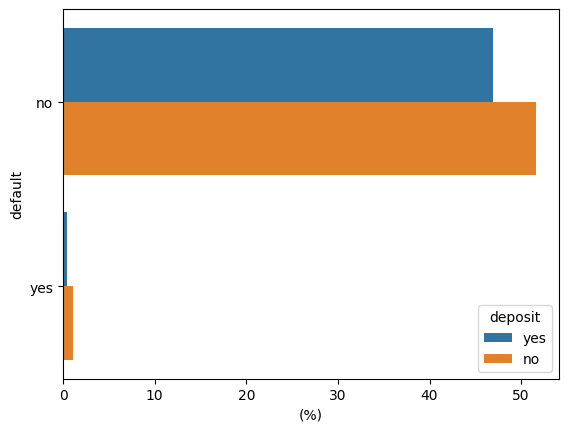

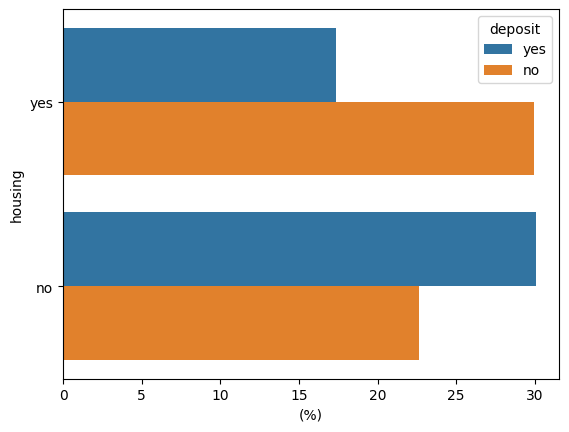

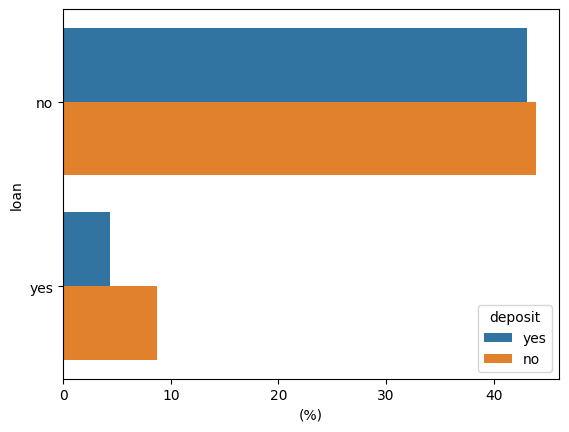

In [9]:
binary_features=['default', 'housing', 'loan']
for feature in binary_features:
    sns.barplot(y=feature, x='balance', hue='deposit', data=df_full, estimator=lambda x: len(x) / len(df_full) * 100).set(xlabel='(%)')
    plt.show()

In [10]:
# prepare new data frame

oh_encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_data = oh_encoder.fit_transform(df_full[categorial_features])
encoded_columns = oh_encoder.get_feature_names_out(categorial_features)
X = pd.DataFrame(encoded_data, columns=encoded_columns)

l_encoder = LabelEncoder()
for feature in binary_features:
    X[feature] = l_encoder.fit_transform(df_full[feature])

X[numerical_features] = StandardScaler().fit_transform(df_full[numerical_features])

y = pd.DataFrame(l_encoder.fit_transform(df_full[target]), columns=[target])

log(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_admin.           11162 non-null  int64  
 1   job_blue-collar      11162 non-null  int64  
 2   job_entrepreneur     11162 non-null  int64  
 3   job_housemaid        11162 non-null  int64  
 4   job_management       11162 non-null  int64  
 5   job_retired          11162 non-null  int64  
 6   job_self-employed    11162 non-null  int64  
 7   job_services         11162 non-null  int64  
 8   job_student          11162 non-null  int64  
 9   job_technician       11162 non-null  int64  
 10  job_unemployed       11162 non-null  int64  
 11  job_unknown          11162 non-null  int64  
 12  marital_divorced     11162 non-null  int64  
 13  marital_married      11162 non-null  int64  
 14  marital_single       11162 non-null  int64  
 15  education_primary    11162 non-null 

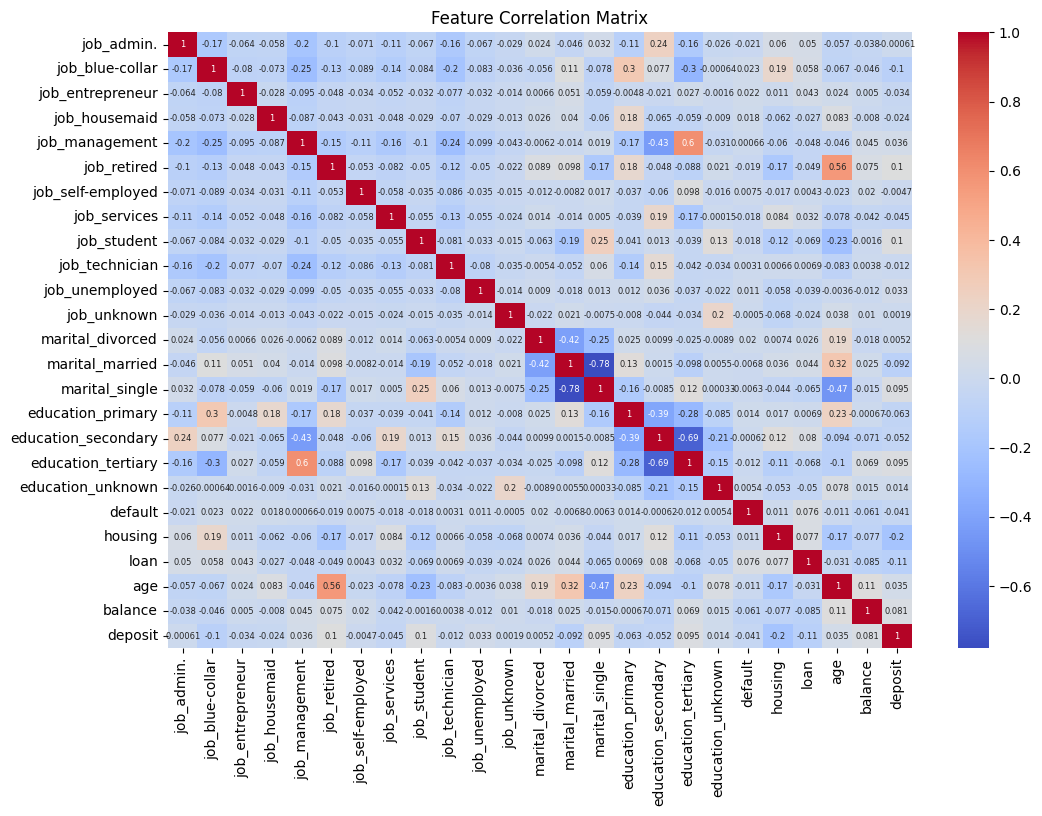

In [11]:
# correlation
plt.figure(figsize=(12, 8))
sns.heatmap(pd.concat((X, y), axis=1).corr(), annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.title("Feature Correlation Matrix")
plt.show()

In [17]:
# train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# kNN Classifier
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, dict(n_neighbors=list(range(1, 31))))
grid_search.fit(X_train, numpy.ravel(y_train))
y_pred = grid_search.best_estimator_.predict(X_test)

log('Best param:', grid_search.best_params_)
log('Accuracy: ', accuracy_score(y_test, y_pred))
log('Classification Report:\n', classification_report(y_test, y_pred))
log('Confusion Matrix:\n', confusion_matrix(Y_test, y_pred))

Best param: {'n_neighbors': 18} 
--------------------------------------------------------------------------------------------------
Accuracy:  0.6306360107494775 
--------------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.75      0.68      1742
           1       0.65      0.50      0.56      1607

    accuracy                           0.63      3349
   macro avg       0.63      0.63      0.62      3349
weighted avg       0.63      0.63      0.62      3349
 
--------------------------------------------------------------------------------------------------
Confusion Matrix:
 [[1313  429]
 [ 808  799]] 
--------------------------------------------------------------------------------------------------


Accuracy:  0.5968945954016124 
--------------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.59      0.60      1742
           1       0.58      0.60      0.59      1607

    accuracy                           0.60      3349
   macro avg       0.60      0.60      0.60      3349
weighted avg       0.60      0.60      0.60      3349
 
--------------------------------------------------------------------------------------------------
Confusion Matrix:
 [[1027  715]
 [ 635  972]] 
--------------------------------------------------------------------------------------------------


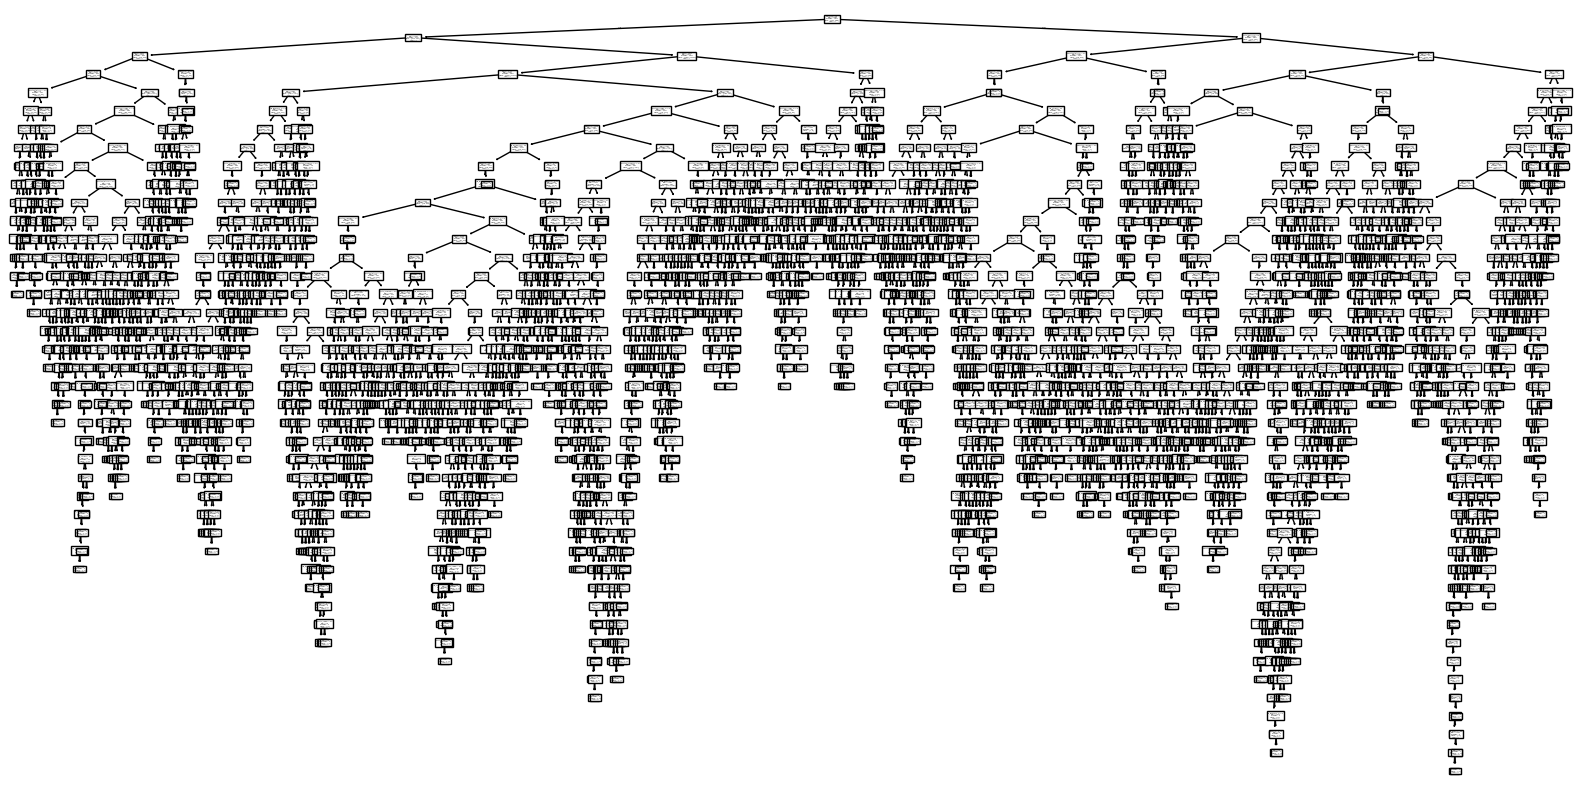

In [38]:
# DecisionTree Classifier
dt = DecisionTreeClassifier(max_depth=100, random_state=42)
dt.fit(X_train, Y_train)
y_pred = dt.predict(X_test)

plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X_train.columns, class_names=['0', '1'])

accuracy = accuracy_score(Y_test, Y_pred)
log('Accuracy: ', accuracy_score(y_test, y_pred))
log('Classification Report:\n', classification_report(y_test, y_pred))
log('Confusion Matrix:\n', confusion_matrix(Y_test, y_pred))

In [51]:
# SVM Classifier
svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, dict(C=[0.1, 1, 10], gamma=[1, 0.1, 0.01]), refit=True)
grid_search.fit(X_train, numpy.ravel(y_train))
y_pred = grid_search.best_estimator_.predict(X_test)

log('Best param:', grid_search.best_params_)
log('Accuracy: ', accuracy_score(y_test, y_pred))
log('Classification Report:\n', classification_report(y_test, y_pred))
log('Confusion Matrix:\n', confusion_matrix(Y_test, y_pred))

Best param: {'C': 0.1, 'gamma': 0.1} 
--------------------------------------------------------------------------------------------------
Accuracy:  0.6401911018214392 
--------------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.72      0.68      1742
           1       0.65      0.55      0.59      1607

    accuracy                           0.64      3349
   macro avg       0.64      0.64      0.64      3349
weighted avg       0.64      0.64      0.64      3349
 
--------------------------------------------------------------------------------------------------
Confusion Matrix:
 [[1261  481]
 [ 724  883]] 
--------------------------------------------------------------------------------------------------


In [44]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, numpy.ravel(y_train))
y_pred = rf.predict(X_test)
log('Accuracy: ', accuracy_score(y_test, y_pred))
log('Classification Report:\n', classification_report(y_test, y_pred))
log('Confusion Matrix:\n', confusion_matrix(Y_test, y_pred))

Accuracy:  0.6327261869214691 
--------------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.66      1742
           1       0.62      0.59      0.61      1607

    accuracy                           0.63      3349
   macro avg       0.63      0.63      0.63      3349
weighted avg       0.63      0.63      0.63      3349
 
--------------------------------------------------------------------------------------------------
Confusion Matrix:
 [[1171  571]
 [ 659  948]] 
--------------------------------------------------------------------------------------------------


In [52]:
# AdaBoost
ada = AdaBoostClassifier(algorithm='SAMME', random_state=42)
ada.fit(X_train, numpy.ravel(y_train))
y_pred = ada.predict(X_test)
log('Accuracy: ', accuracy_score(y_test, y_pred))
log('Classification Report:\n', classification_report(y_test, y_pred))
log('Confusion Matrix:\n', confusion_matrix(Y_test, y_pred))

Accuracy:  0.645267243953419 
--------------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68      1742
           1       0.65      0.55      0.60      1607

    accuracy                           0.65      3349
   macro avg       0.65      0.64      0.64      3349
weighted avg       0.65      0.65      0.64      3349
 
--------------------------------------------------------------------------------------------------
Confusion Matrix:
 [[1271  471]
 [ 717  890]] 
--------------------------------------------------------------------------------------------------
